## Figures

- Figure ST3 A,D

## Required files

- `models_dir / 'seq_model.pkl'` - chipseq model
- `rdir / 'src/chipnexus/train/seqmodel/ChIP-seq.dataspec.yml'`  -> chipseq raw files
- `model_dir / f'deeplift/{t}/out/{imp_score}/centroid_seqlet_matches.csv'`
- `model_dir / f'deeplift/{t}/out/{imp_score}/modisco.h5'`

## Produced files

- Figure ST3 D
  - `{figures}/known_enhancer_profiles/Oct4-distal-enhancer.150bp.pdf`
- Figure ST3A
  - `{figures}/known_enhancer_profiles/{name}.pred-vs-obs.1kb.pdf`

In [1]:
from collections import OrderedDict
exp = 'seq,peaks,OSN,0,10,1,FALSE,same,0.5,64,50,0.004,9,FALSE,[1,50],TRUE,TRUE'
imp_score = 'profile/wn'

motifs = OrderedDict([
    ("Oct4-Sox2", "Oct4/m0_p0"),
    ("Oct4", "Oct4/m0_p5"),
    ("Sox2", "Sox2/m0_p1"),
    ("Nanog", "Nanog/m0_p1")
])

gpu = 2  # Set to None if GPU shouldn't be used

motifs_inv = {v:k for k,v in motifs.items()}

## Goal

- Visualize the Oct4-distal enhancer region

In [2]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from basepair.imports import *

from basepair.exp.paper.config import *
from basepair.seqmodel import SeqModel
from basepair.BPNet import model2tasks
from basepair.models import seq_bpnet_cropped_extra_seqlen
from basepair.preproc import resize_interval, parse_interval
from basepair.seqmodel import SeqModel
from basepair.utils import unflatten
from genomelake.extractors import FastaExtractor
from concise.preprocessing.sequence import one_hot2string, DNA
from kipoi.utils import unique_list

import pybedtools
from basepair.utils import flatten_list
paper_config()

Using TensorFlow backend.


In [3]:
if gpu is not None:
    create_tf_session(gpu)

In [4]:
# Common paths
model_dir = models_dir / exp
# figures = f"{ddir}/figures/model-evaluation/chipnexus-bpnet/{exp}/known_enhancer_profiles"
figures = Path(f'{ddir}/figures/modisco/{exp}')

!mkdir -p {figures}/known_enhancer_profiles

In [5]:
# Dataspec
ds = DataSpec.load(rdir / 'src/chipnexus/train/seqmodel/ChIP-seq.dataspec.yml')

In [6]:
tasks = ['Oct4', 'Sox2', 'Nanog']

In [7]:
from basepair.modisco.results import MultipleModiscoResult
from basepair.modisco.pattern_instances import (multiple_load_instances, load_instances, filter_nonoverlapping_intervals, 
                                                plot_coocurence_matrix, align_instance_center, dfi2seqlets, annotate_profile)

def shorten_te_pattern(s):
    tf, p = s.split("/", 1)
    return tf + "/" + shorten_pattern(p)

mr = MultipleModiscoResult({t: model_dir / f'deeplift/{t}/out/{imp_score}/modisco.h5'
                           for t in tasks})

centroid_seqlet_matches = {t: pd.read_csv(model_dir / f'deeplift/{t}/out/{imp_score}/centroid_seqlet_matches.csv')
                           for t in tasks}

patterns = [p.trim_seq_ic(0.08) for p in mr.get_all_patterns()
            if shorten_te_pattern(p.name) in list(motifs.values())]

TF-MoDISco is using the TensorFlow backend.


In [8]:
bpnet = SeqModel.from_mdir(model_dir)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


2019-04-27 01:28:43,242 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
Use the retry module or similar alternatives.


2019-04-27 01:28:54,226 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


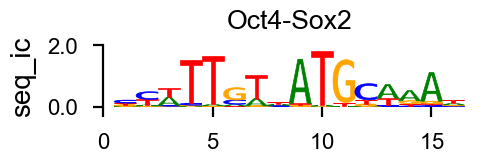

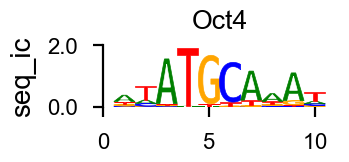

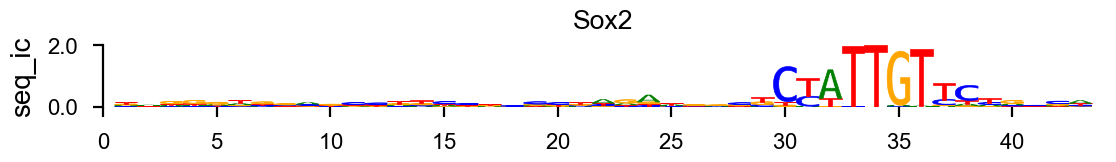

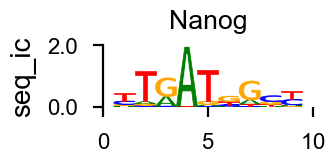

In [9]:
for p in patterns:
    p.plot('seq_ic', height=0.4, letter_width=0.15);
    sns.despine(top=True, bottom=True, right=True)
    plt.title(motifs_inv[shorten_te_pattern(p.name)])
    plt.ylim([0,2])

## Get predictions and importance scores

In [9]:
from basepair.exp.paper.locus import *

In [10]:
# Generate the right colors
colors = []
for task in tasks:
    colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5
    colors.append(None)

In [11]:
interval = parse_interval("chr17:35503550-35504550")

In [12]:
interval.end - interval.start

1000

In [62]:
viz_dict, seq, imp_scores = interval_predict(bpnet, ds, interval, tasks, smooth_obs_n=25, neg_rev=False)

xlim = [420, 575]  # Focus only on the 420 - 575 region
viz_dict = filter_tracks(viz_dict, xlim)

# instances
dfim = get_instances(patterns, seq, imp_scores, imp_score, centroid_seqlet_matches, motifs, tasks).query('match_weighted_p > .2')
seqlets = dfi2seqlets(dfim, motifs_inv)
seqlets2 = [s.shift(-xlim[0]) for s in seqlets]

In [63]:
print(one_hot2string(seq[:, slice(*xlim)], DNA)[0])  # Get the sequence

GGAGGAACTGGGTGTGGGGAGGTTGTAGCCCGACCCTGCCCCTCCCCCCAGGGAGGTTGAGAGTTCTGGGCAGACGGCAGATGCATAACAAAGGTGCATGATAGCTCTGCCCTGGGGGCAGAGAAGATGGTTGGGGAGGGGTCCCTCTCGTCCTA


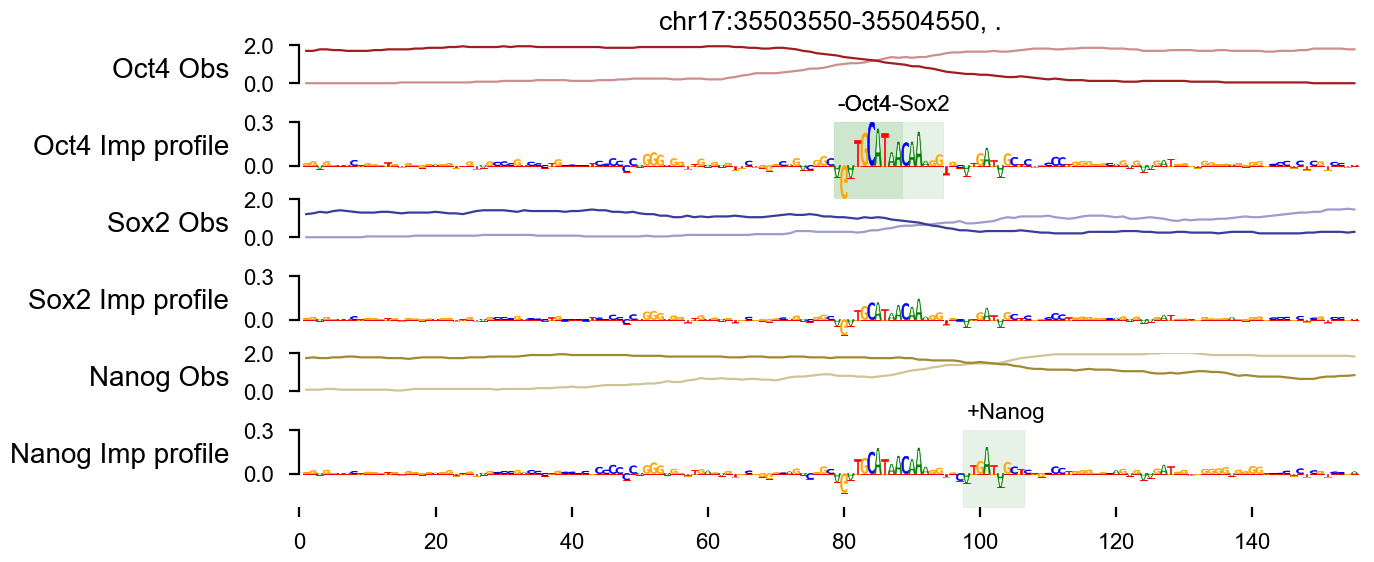

In [64]:
fig = plot_tracks(viz_dict,
                  #seqlets=shifted_seqlets,
                  title="{i.chrom}:{i.start}-{i.end}, {i.name}".format(i=interval),
                  fig_height_per_track=0.5,
                  rotate_y=0,
                  fig_width=get_figsize(frac=1)[0],
                  use_spine_subset=True,
                  seqlets=seqlets2,
                  color=colors,
                  ylim=get_ylim(viz_dict, tasks),
                  legend=False)
sns.despine(top=True, right=True, bottom=True)

In [66]:
!mkdir -p {figures}/known_enhancer_profiles/all-motifs

In [67]:
fig.savefig(f"{figures}/known_enhancer_profiles/all-motifs/distal_oct4.pred,imp,imp-counts.pdf")

In [68]:
from basepair.plot.tracks import *

Taken from: https://docs.google.com/spreadsheets/d/1nIRLv3tWq_3BjorP_pEAyJKWtVClX6_OrE2waN94ECc/edit#gid=0

## Plot the individual locus using all the datapoints

In [132]:
class PlotTrackWRug:
    def __init__(self, xlim):
        self.xlim = xlim

    def __call__(self, arr, ax, legend=False, ylim=None, color=None, track=None):
        """Tracks with a rug plot for '*Obs*' tracks
        """
        import collections
        from concise.utils.pwm import seqlogo
        seqlen = self.xlim[1] - self.xlim[0]
        
        sl = slice(self.xlim[0], self.xlim[1])
        if arr.shape[1] == 4:
            # plot seqlogo
            seqlogo(arr[sl], ax=ax)
        elif arr.shape[1] == 2:
            # plot both strands
            if color is not None:
                assert isinstance(color, collections.Sequence)
                c1 = color[0]
                c2 = color[1]
            else:
                c1, c2 = None, None

            if 'Obs' in track:
                y_smooth = moving_average(arr, n=50)
                ax.plot(np.arange(1, seqlen + 1), y_smooth[sl,0], label='pos', color=c1)
                ax.plot(np.arange(1, seqlen + 1), y_smooth[sl,1], label='neg', color=c2)

                # Rugs
                rug_pos = np.where(arr[sl, 0]>=1)[0] + 1
                rug_neg = np.where(arr[sl, 1]>=1)[0] + 1
                sns.rugplot(rug_pos, color=c1, alpha=0.3, ax=ax, height=.1)
                sns.rugplot(rug_neg, color=c2, alpha=0.3, ax=ax, height=.1)
            else:
                ax.plot(np.arange(1, seqlen + 1), arr[sl, 0], label='pos', color=c1)
                ax.plot(np.arange(1, seqlen + 1), arr[sl, 1], label='neg', color=c2)

            if legend:
                ax.legend()
        else:
            raise ValueError(f"Don't know how to plot array with shape[1] != {arr.shape[1]}. Valid values are: 1,2 or 4.")
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.set_xlim([0, seqlen])

### Oct4 enhancer

In [ ]:
interval_predict??

In [127]:
interval = parse_interval("chr17:35503550-35504550")

viz_dict, seq, imp_scores = interval_predict(bpnet, ds, interval, tasks, smooth_obs_n=0, neg_rev=False, incl_pred=True)
viz_dict_smooth = {k: moving_average(v, n=50) if 'Obs'in k else v for k,v in viz_dict.items()}

xlim = [450, 570]  # Focus only on the 420 - 575 region
# viz_dict = filter_tracks(viz_dict, xlim)

# instances
dfim = get_instances(patterns, seq, imp_scores, imp_score, centroid_seqlet_matches, motifs, tasks).query('match_weighted_p > .2')
seqlets = dfi2seqlets(dfim, motifs_inv)
seqlets2 = [s.shift(-xlim[0]) for s in seqlets]

In [122]:
print(one_hot2string(seq[:, slice(*xlim)], DNA)[0])  # Get the sequence

CGACCCTGCCCCTCCCCCCAGGGAGGTTGAGAGTTCTGGGCAGACGGCAGATGCATAACAAAGGTGCATGATAGCTCTGCCCTGGGGGCAGAGAAGATGGTTGGGGAGGGGTCCCTCTCG


In [128]:
# Generate the right colors
colors = []
for task in tasks:
    colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5
    colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5
    colors.append(None)

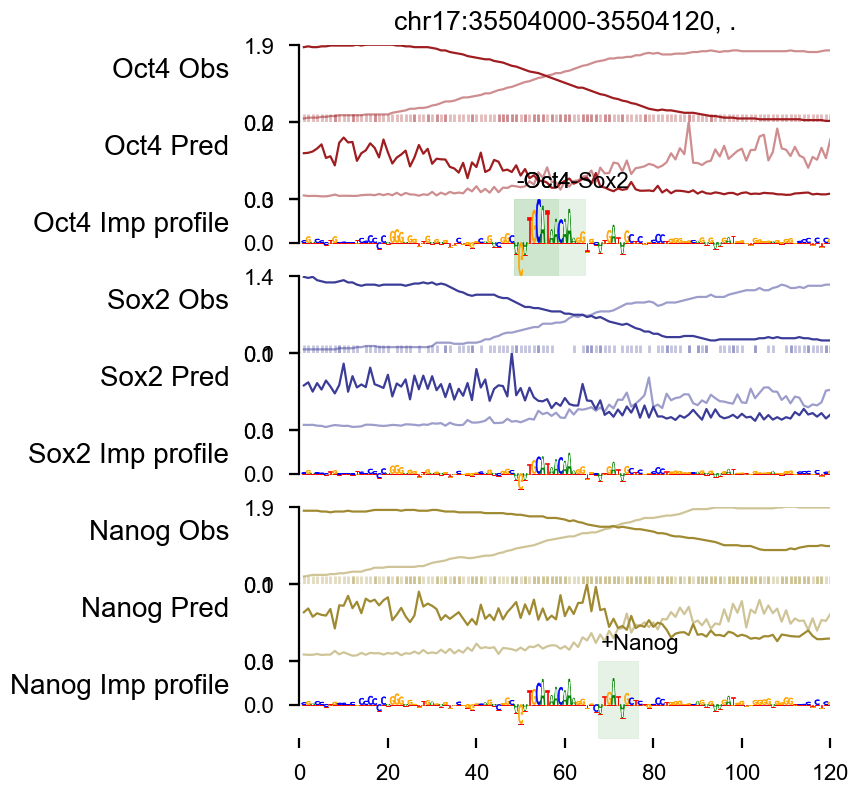

In [129]:
fig = plot_tracks(viz_dict,
                  title=str_interval(interval, xlim),
                  fig_height_per_track=0.5,
                  rotate_y=0,
                  fig_width=get_figsize(frac=.5)[0],
                  use_spine_subset=True,
                  seqlets=seqlets2,
                  color=colors,
                  ylim=get_ylim(viz_dict_smooth, tasks, profile_per_tf=True, neg_rev=False),
                  legend=False,
                  plot_track_fn=PlotTrackWRug(xlim))
sns.despine(top=True, right=True, bottom=True)
fig.savefig(f"{figures}/known_enhancer_profiles/Oct4-distal-enhancer.150bp.pdf")

### Other enhancers

In [133]:
def plot_track_w_rug(arr, ax, legend=False, ylim=None, color=None, track=None):
    """Tracks with a rug plot for '*Obs*' tracks
    """
    import collections
    from concise.utils.pwm import seqlogo
    seqlen = len(arr)
    if arr.shape[1] == 4:
        # plot seqlogo
        seqlogo(arr, ax=ax)
    elif arr.shape[1] == 2:
        # plot both strands
        if color is not None:
            assert isinstance(color, collections.Sequence)
            c1 = color[0]
            c2 = color[1]
        else:
            c1, c2 = None, None
        
        if 'Obs' in track:
            y_smooth = moving_average(arr, n=50)
            ax.plot(np.arange(1, seqlen + 1), y_smooth[:,0], label='pos', color=c1)
            ax.plot(np.arange(1, seqlen + 1), y_smooth[:,1], label='neg', color=c2)
            
            # Rugs
            rug_pos = np.where(arr[:, 0]>=1)[0] + 1
            rug_neg = np.where(arr[:, 1]>=1)[0] + 1
            sns.rugplot(rug_pos, color=c1, alpha=0.3, ax=ax, height=.1)
            sns.rugplot(rug_neg, color=c2, alpha=0.3, ax=ax, height=.1)
        else:
            ax.plot(np.arange(1, seqlen + 1), arr[:, 0], label='pos', color=c1)
            ax.plot(np.arange(1, seqlen + 1), arr[:, 1], label='neg', color=c2)
        
        if legend:
            ax.legend()
    else:
        raise ValueError(f"Don't know how to plot array with shape[1] != {arr.shape[1]}. Valid values are: 1,2 or 4.")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlim([0, seqlen])

In [134]:
# chr1:136680205-136680605 (known Zfp281 enhancer) 
# chr1:180924752-180925152 (known Letfy1 enhancer) 
intervals = [
    ('known Zfp281 enhancer', 'chr1:136680205-136680605'),
    ('known Letfy1 enhancer', 'chr1:180924752-180925152'),
]

In [73]:
i = 0
name, int_str = intervals[i]
interval = parse_interval(int_str)
viz_dict, seq, imp_scores = interval_predict(bpnet, ds, interval, tasks, smooth_obs_n=0, neg_rev=False, incl_pred=True)
# viz_dict = {k:v for k,v in viz_dict.items() if 'Imp' not in k}  # remove importance scores

xlim= [0, 1000]
# xlim = [420, 575]  # Focus only on the 420 - 575 region
# viz_dict = filter_tracks(viz_dict, xlim)

# instances
dfim = get_instances(patterns, seq, imp_scores, imp_score, centroid_seqlet_matches, motifs, tasks).query('match_weighted_p > .2')
seqlets = dfi2seqlets(dfim, motifs_inv)
seqlets2 = [s.shift(-xlim[0]) for s in seqlets]

# for computing the y axis
viz_dict_smooth = {k: moving_average(v, n=50) if 'Obs'in k else v for k,v in viz_dict.items()}

resizing the interval of length 400 to 1000


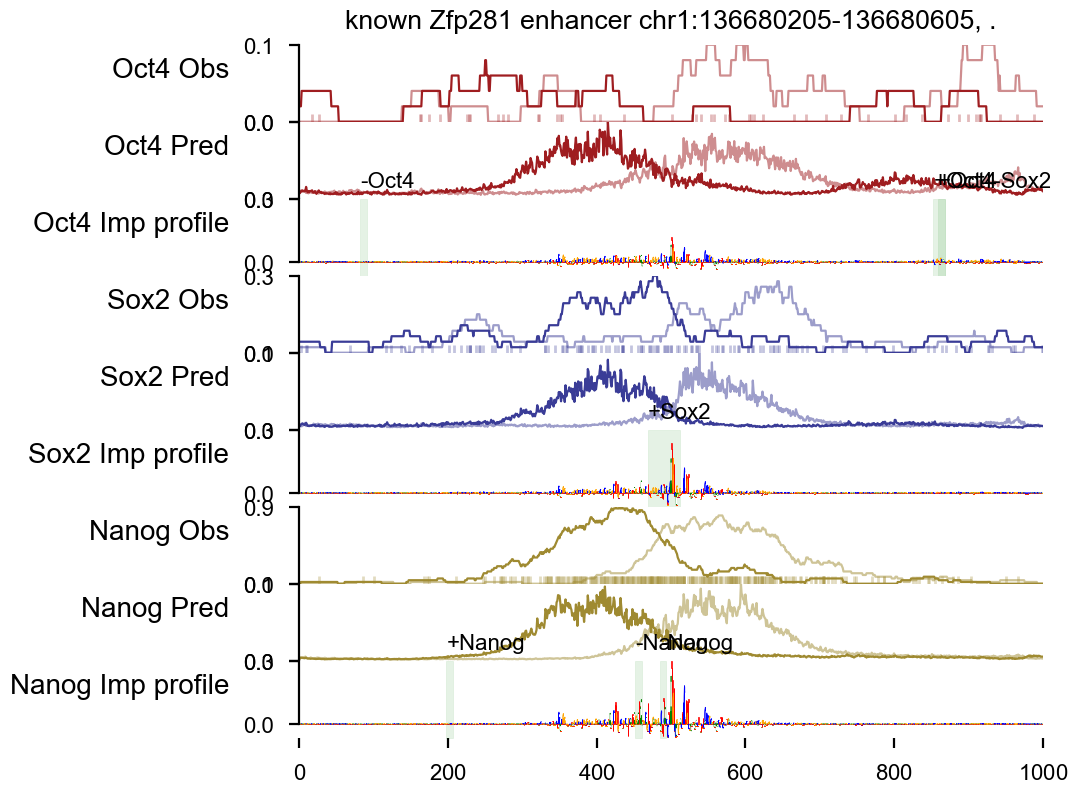

In [74]:
fig = plot_tracks(viz_dict,
                  #seqlets=shifted_seqlets,
                  title=name + " {i.chrom}:{i.start}-{i.end}, {i.name}".format(i=interval),
                  fig_height_per_track=0.5,
                  rotate_y=0,
                  fig_width=get_figsize(frac=.7)[0],
                  use_spine_subset=True,
                  seqlets=seqlets2,
                  color=colors,
                  ylim=get_ylim(viz_dict_smooth, tasks, profile_per_tf=True, neg_rev=False),
                  plot_track_fn=plot_track_w_rug,
                  legend=False)
sns.despine(top=True, right=True, bottom=True)
# fig.savefig(f"{figures}/known_enhancer_profiles/Oct4-distal-enhancer.150bp.pdf")

In [75]:
i = 1
name, int_str = intervals[i]
interval = parse_interval(int_str)
viz_dict, seq, imp_scores = interval_predict(bpnet, ds, interval, tasks, smooth_obs_n=0, neg_rev=False, incl_pred=True)
# viz_dict = {k:v for k,v in viz_dict.items() if 'Imp' not in k}  # remove importance scores
xlim= [0, 1000]
# xlim = [420, 575]  # Focus only on the 420 - 575 region
# viz_dict = filter_tracks(viz_dict, xlim)

# instances
dfim = get_instances(patterns, seq, imp_scores, imp_score, centroid_seqlet_matches, motifs, tasks).query('match_weighted_p > .2')
seqlets = dfi2seqlets(dfim, motifs_inv)
seqlets2 = [s.shift(-xlim[0]) for s in seqlets]

# for computing the y axis
viz_dict_smooth = {k: moving_average(v, n=50) if 'Obs'in k else v for k,v in viz_dict.items()}

resizing the interval of length 400 to 1000


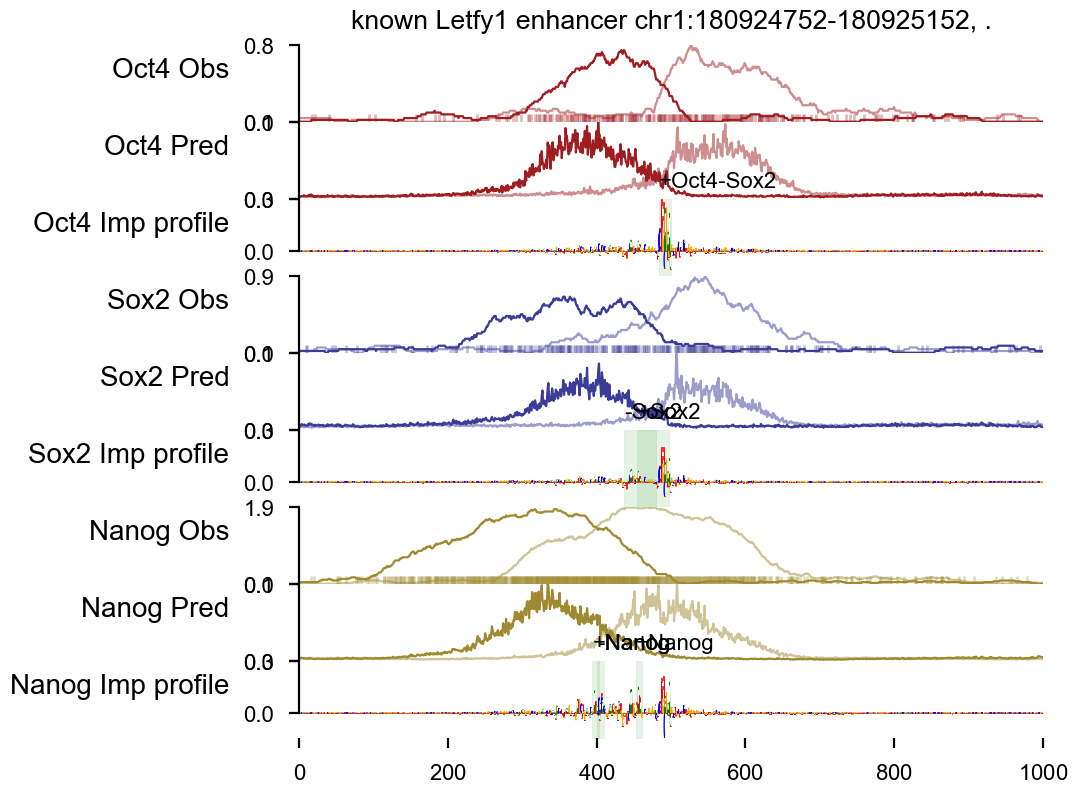

In [76]:
fig = plot_tracks(viz_dict,
                  #seqlets=shifted_seqlets,
                  title=name + " {i.chrom}:{i.start}-{i.end}, {i.name}".format(i=interval),
                  fig_height_per_track=0.5,
                  rotate_y=0,
                  fig_width=get_figsize(frac=.7)[0],
                  use_spine_subset=True,
                  seqlets=seqlets2,
                  color=colors,
                  ylim=get_ylim(viz_dict_smooth, tasks, profile_per_tf=True, neg_rev=False),
                  plot_track_fn=plot_track_w_rug,
                  legend=False)
sns.despine(top=True, right=True, bottom=True)
# fig.savefig(f"{figures}/known_enhancer_profiles/Oct4-distal-enhancer.150bp.pdf")

### Without importance scores

In [139]:
# Generate the right colors
colors = []
for task in tasks:
    colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5
    colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5

In [140]:
from basepair.preproc import shift_interval

In [141]:
i = 0
name, int_str = intervals[i]
interval = shift_interval(parse_interval(int_str), 200)
viz_dict, seq, imp_scores = interval_predict(bpnet, ds, interval, tasks, smooth_obs_n=0, neg_rev=False, incl_pred=True)
viz_dict = {k:v for k,v in viz_dict.items() if 'Imp' not in k}  # remove importance scores

xlim= [0, 1000]

# for computing the y axis
viz_dict_smooth = {k: moving_average(v, n=50) if 'Obs'in k else v for k,v in viz_dict.items()}

resizing the interval of length 400 to 1000


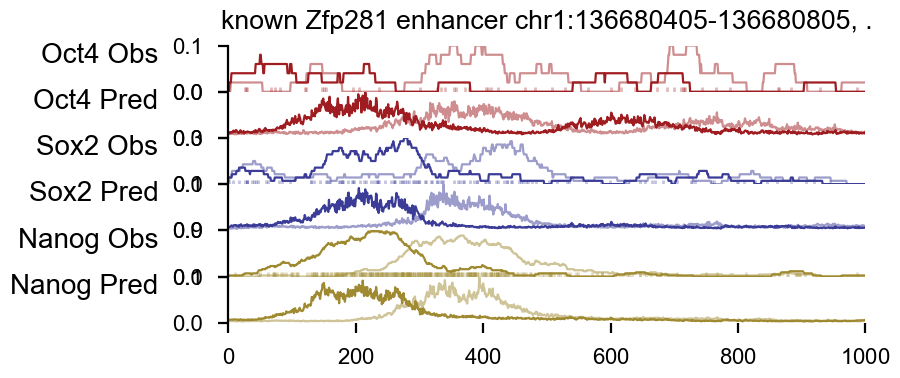

In [142]:
fig = plot_tracks(viz_dict,
                  #seqlets=shifted_seqlets,
                  title=name + " {i.chrom}:{i.start}-{i.end}, {i.name}".format(i=interval),
                  fig_height_per_track=0.3,
                  rotate_y=0,
                  fig_width=get_figsize(frac=.6)[0],
                  use_spine_subset=True,
                  color=colors,
                  ylim=get_ylim(viz_dict_smooth, tasks, profile_per_tf=True, neg_rev=False),
                  plot_track_fn=plot_track_w_rug,
                  legend=False)
sns.despine(top=True, right=True, bottom=True)
fig.savefig(f"{figures}/known_enhancer_profiles/{name}.pred-vs-obs.1kb.pdf")

In [143]:
i = 1
name, int_str = intervals[i]
interval = shift_interval(parse_interval(int_str), -200)
viz_dict, seq, imp_scores = interval_predict(bpnet, ds, interval, tasks, smooth_obs_n=0, neg_rev=False, incl_pred=True)
viz_dict = {k:v for k,v in viz_dict.items() if 'Imp' not in k}  # remove importance scores

xlim= [0, 1000]

# for computing the y axis
viz_dict_smooth = {k: moving_average(v, n=50) if 'Obs'in k else v for k,v in viz_dict.items()}

resizing the interval of length 400 to 1000


In [144]:
figures

PosixPath('/users/avsec/workspace/basepair/data/figures/modisco/seq,peaks,OSN,0,10,1,FALSE,same,0.5,64,50,0.004,9,FALSE,[1,50],TRUE,TRUE')

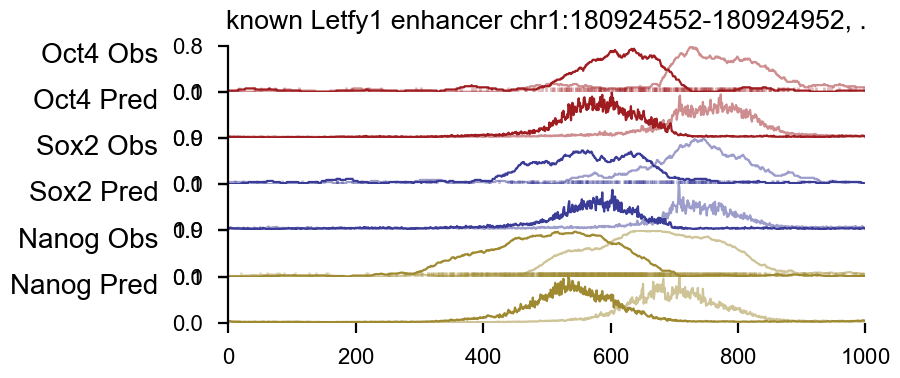

In [145]:
fig = plot_tracks(viz_dict,
                  #seqlets=shifted_seqlets,
                  title=name + " {i.chrom}:{i.start}-{i.end}, {i.name}".format(i=interval),
                  fig_height_per_track=0.3,
                  rotate_y=0,
                  fig_width=get_figsize(frac=.6)[0],
                  use_spine_subset=True,
                  color=colors,
                  ylim=get_ylim(viz_dict_smooth, tasks, profile_per_tf=True, neg_rev=False),
                  plot_track_fn=plot_track_w_rug,
                  legend=False)
sns.despine(top=True, right=True, bottom=True)
fig.savefig(f"{figures}/known_enhancer_profiles/{name}.pred-vs-obs.1kb.pdf")